In [4]:

from  datetime import datetime
import sys
import heapq
from math import sqrt
from itertools import chain
import numpy as np
from sklearn.preprocessing import *
import random
import matplotlib.pyplot as plt
import scanpy as sc
sc.settings.set_figure_params(dpi=80)
import umap
from datetime import datetime
from sklearn.metrics import *
from sklearn.mixture import GaussianMixture
import sys
import pandas as pd
import anndata as ad
sys.path.append('/home/yzy/software2/FINCH-Clustering/python/')
sys.path.append('/home/yzy/software/pysnic-master/')
sys.path.append('/home/yzy/bioSIMS/code/analysis')
from utils import *
from finch import FINCH
import faiss                   # make faiss available

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/pbmc3k.h5ad'  # the file that will store the analysis result
sc.settings.set_figure_params(dpi=80)

Using TensorFlow backend.
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/yzy/anacond

scanpy==1.4.3+56.g709bafb anndata==0.6.18 umap==0.3.10 numpy==1.17.3 scipy==1.2.1 pandas==0.23.4 scikit-learn==0.20.2 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1


In [5]:
class QueueElement(object):
    __sub_index = 0

    def __init__(self, key, value):
        self._key = key
        self.value = value

    def __lt__(self, other):
        """
        :type other: QueueElement
        """
        return self._key < other._key


class Queue(object):
    def __init__(self, _buffer_size=0):
        # TODO we perform a lot of single insertions
        # it would be more efficient to use a cache class that already contains a buffer of the maximum  heap size
        # But since heapq is implemented in C, a custom python implementation will probably be slower
        self.heap = []

    def add(self, priority, value):
        heapq.heappush(self.heap, QueueElement(priority, value))

    def is_empty(self):
        return len(self.heap) == 0

    def pop_value(self):
        item = heapq.heappop(self.heap)
        return item.value

    def pop(self):
        return heapq.heappop(self.heap)

    def length(self):
        return len(self.heap)
    
    
def lerp2(a, b, w):
    return [
        (a[0] * (1 - w)) + (b[0] * w),
        (a[1] * (1 - w)) + (b[1] * w)]

def lerp_nd(a, b, w):
    u = 1 - w

    def lerp1_w(x, y):
        return (x * u) + (y * w)
    return list(map(lerp1_w, a, b))

def norm2_sqr(x, y):
    """
    Squared 2-norm for 2d vectors
    :param x:
    :param y:
    :return:
    """
    return (x * x) + (y * y)
def norm_nd_sqr_arr(a, b):
    def sub_sqr(x, y):
        d = x - y
        return d * d
    return sum(map(sub_sqr, a, b))


def snic_distance_mod(pos_i, pos_j, col_i, col_j, si, mi):
    """
    Computes the SNIC pixel distance
    None of the components can be negative -> omitting the root does not change item order
    :param pos_i: position of pixel i
    :param pos_j: position of pixel j
    :param col_i: color of pixel i
    :param col_j: color of pixel j
    :param si: inverted spatial normalization factor = 1 / np.sqrt(num_pixels_in_image/num_super_pixels)
    :param mi: inverted (-> 1/x) user provided (color) compactness factor - higher -> more compact, poorer boundary adherence
    :return: distance value
    """

    pos_d = norm2_sqr(pos_j[0] - pos_i[0], pos_j[1] - pos_i[1]) * si
    col_d = norm_nd_sqr_arr(col_i, col_j) * mi
    distance = pos_d + col_d
    return distance


def create_augmented_snic_distance(num_points, number_of_superpixels, compactness_img,compactness_col):
    #compactness_img:median of min(point-point distance)^2
    # compute normalization factors
    si = 1 / sqrt((num_points) / number_of_superpixels)
    si = si/compactness_img
    mi = 1 / float(compactness_col)

    def snic_distance_augmented(pa, pb, ca, cb, ss=si, mm=mi):
        return snic_distance_mod(pa, pb, ca, cb, ss, mm)
    return snic_distance_augmented

def get_k_neighbourhood_and_compactness_img(k, spatial_key):
    num_points = len(spatial_key)
    spatial_key_np = np.array(spatial_key).astype('float32')
    
    index = faiss.IndexFlatL2(2)   # build the index
#     print(index.is_trained)
    index.add(spatial_key_np)                  # add vectors to the index
#     print(index.ntotal)

                             
    D, I = index.search(spatial_key_np, k+1) # sanity check
    
    
    
#     spatial_distmat = squareform(pdist(spatial_key))
#     spatial_distmat_argsort = np.argsort(spatial_distmat)
#     spatial_distmat_sort = np.take_along_axis(spatial_distmat, spatial_distmat_argsort, axis=1)
    spatial_distmat_sort = D
    spatial_distmat_argsort = I
    compactness_img = np.median(spatial_distmat_sort[:,1])
    compactness_img = np.square(compactness_img)
    
#     list(num_points) of list(k) of neighbor idx
    neighbor_list = []
    for i in range(num_points):
        cur_neighbors_idx = list(spatial_distmat_argsort[i,1:1+k])
        neighbor_list.append(cur_neighbors_idx)
    neighbor_dict = dict(zip(spatial_key,neighbor_list))
    
    return neighbor_dict,compactness_img

In [62]:
def ST_snic(adata,compactness_col,neighbor_k,num_grid):
    image_full = adata.copy()
#     compactness_col = 1
#     neighbor_k = 4

#     update_func = None
    image_distance=None
    #把image转为3维[0,1]
    sc.pp.normalize_per_cell(image_full)
    sc.pp.log1p(image_full)
    image_full.raw = image_full
    sc.tl.pca(image_full, svd_solver='arpack')
    sc.pp.neighbors(image_full)
    sc.tl.umap(image_full,n_components=3)
    sc.tl.louvain(image_full)


    num_points = image_full.shape[0]
    spatial_key = [(image_full.obs['spatial_x'][i],image_full.obs['spatial_y'][i]) for i in range(num_points)]
    label_map_val = [-1]*num_points
    distance_map_val = [sys.float_info.max]*num_points
    image_val = [image_full.obsm['X_umap'][i] for i in range(num_points)]

    # [x,y]->label
    label_map = dict(zip(spatial_key,label_map_val))

    # [x,y]->distance to centroid
    distance_map = dict(zip(spatial_key,distance_map_val))

    # [x,y]->np.array of (3,)
    image = dict(zip(spatial_key,image_val))

    # calculate compactness_img
    neighbor_dict,compactness_img = get_k_neighbourhood_and_compactness_img(neighbor_k, spatial_key)


    # list of tuple (x,y)
    grid = None
#     num_grid = 200
    grid_idx = np.random.choice(num_points,num_grid,replace=False)
    grid = [spatial_key[i] for i in grid_idx]
    real_number_of_pixels = len(grid)

    centroids_pos = grid
    centroids = [[pos,image[pos],0] for pos in centroids_pos]


    queue = Queue(num_points * 4)  # [position, color, centroid_idx]
    q_add = queue.add  # cache some functions
    q_pop = queue.pop

    for k in range(real_number_of_pixels):
        init_centroid = centroids[k]
        q_len = -queue.length()
        q_add(q_len, [init_centroid[0], init_centroid[1], k])
        distance_map[init_centroid[0]] = q_len

    if image_distance is None:
        image_distance = create_augmented_snic_distance(num_points, real_number_of_pixels, compactness_img,compactness_col)

    update_func=lambda num_pixels: print("processed %05.2f%%" % (num_pixels * 100 / number_of_pixels))
    number_of_pixels=num_points


    classified_pixels = 0
    try:
        while True:
    #         print('aaa')
            item = q_pop()
            candidate_distance = item._key
            candidate = item.value
            candidate_pos = candidate[0]
            if label_map[candidate_pos] == -1:
                centroid_idx = candidate[2]
    #             print('bbb')

                # label new pixel
                label_map[candidate_pos] = centroid_idx
                #
                distance_map[candidate_pos] = candidate_distance
                # label_map[candidate_pos[1] * im_width + candidate_pos[0]] = centroid_idx
                classified_pixels += 1

                # online update of centroid
                centroid = centroids[centroid_idx]
                num_pixels = centroid[2] + 1
                lerp_ratio = 1 / num_pixels

                # adjust centroid position
                centroid[0] = lerp2(centroid[0], candidate_pos, lerp_ratio)
                # update centroid color
                centroid[1] = lerp_nd(centroid[1], candidate[1], lerp_ratio)
                # adjust number of pixels counted towards this super pixel
                centroid[2] = num_pixels

                # add new candidates to queue
                #!!!!!!!!!!!!!!!!!可以提前算好
    #             neighbours, neighbour_num = get_4_neighbourhood_1(candidate_pos, image_size)
                neighbours_idx = neighbor_dict[candidate_pos]
                neighbour_num = len(neighbours_idx)
                neighbours = [spatial_key[i] for i in neighbours_idx]
                for i in range(neighbour_num):
                    neighbour_pos = neighbours[i]
                    # Check if neighbour is already labeled, as these pixels would get discarded later on.
                    # We filter them here as queue insertions are expensive
                    # if label_map[neighbour_pos[1] * im_width + neighbour_pos[0]] == -1:
                    if label_map[neighbour_pos] == -1:
                        neighbour_color = image[neighbour_pos]
                        neighbour = [neighbour_pos, neighbour_color, centroid_idx]
                        #!!!!!!!!!!!!!!!!!
                        distance = image_distance(neighbour_pos, centroid[0], neighbour_color, centroid[1])

                        # test if another candidate with a lower distance, is not already
                        # registered to this pixel
                        if distance_map[neighbour_pos] >= distance:
                            distance_map[neighbour_pos] = distance
                            q_add(distance, neighbour)

                # status update
                if (update_func is not None) and (classified_pixels % 10000 == 0):
                    update_func(classified_pixels)
    except IndexError:
        pass
    
    image_full.obs['snic_c']=[label_map[image_full.obs['spatial_x'][i],image_full.obs['spatial_y'][i]] for i in range(num_points)]
    image_full.obs['snic_d'] = image_full.obs['snic_c'].astype('category')

    return image_full, distance_map, real_number_of_pixels

def get_gene_rep(adata):
    image_full_2 = adata.copy()
    cell_avg_mat = []
    for i in np.unique(image_full_2.obs['snic_d']):
        cur_ad = image_full_2[image_full_2.obs['snic_d']==i]
    #     换成mean？

        if cur_ad.shape[0]==1:
            cur_avg = np.array(cur_ad.X)[:,None]
        else:
            cur_avg = np.array(np.sum(cur_ad.X,axis=0,keepdims=1))
            cur_avg = np.transpose(cur_avg)
    #     cur_avg = np.transpose(cur_avg)
        cell_avg_mat.append(cur_avg)
    gene_repmat = np.concatenate(cell_avg_mat,axis=1)
    return list(image_full_2.var_names),gene_repmat

# slide seq data loading

In [6]:
slideseq_root = '/home/yzy/PUBDT/st/slideseq/'
slideseq_name = 'Puck_180413_7'

# read count
# g个基因，n个细胞，每一行是一个基因，前两列是ENSEMBL／gene；其后是按顺序的细胞
gene_list = []
ENSEMBL_list = []
cell_list = []
count_list = []
slideseq_count_file = slideseq_root+slideseq_name+'.count'
with open(slideseq_count_file,'r') as f:
    i=0
    for line in f:
        line = str.strip(line)
        line_sp = line.split(',')
        if i==0:
            cell_list = line_sp[2:]
        else:
            ENSEMBL_list.append(line_sp[0])
            gene_list.append(line_sp[1])
            count_list.append(line_sp[2:])
        i+=1
# g*n
count_mat = np.array(count_list).astype('int')


cellid_list=[]
index_list=[]
x_list=[]
y_list=[]
slideseq_index_file = slideseq_root+slideseq_name+'.idx'
with open(slideseq_index_file) as f:
    i=0
    for line in f:
        line = str.strip(line)
        line_sp = line.split(',')
        if i==0:
            i+=1
            continue
        else:
            cellid_list.append(line_sp[0])
            index_list.append(line_sp[1])
            x_list.append(line_sp[2])
            y_list.append(line_sp[3])
        i+=1
x_list = np.array(x_list).astype('float32')
y_list = np.array(y_list).astype('float32')
            

# ST data loading

In [154]:
ST_root = '/home/yzy/PUBDT/st/Spatial_transcriptomics/Spatial_maps/'
ST_name = 'P3.2'

# read count
# g个基因，n个细胞，每一行是一个基因，前两列是ENSEMBL／gene；其后是按顺序的细胞
gene_list = []
ENSEMBL_list = []
cell_list = []
count_list = []
ST_count_file = ST_root+ST_name+'.count'

ST_index_file = ST_root+ST_name+'.idx'
spot_coor_dict = {}
spot_list = []
x_list = []
y_list = []
with open(ST_index_file) as f:
    i=0
    for line in f:
        line = line.strip()
        if i==0:
            
            spot_list_pre = line.split('\t')
            spot_list = spot_list_pre[1:]
        elif i==1:
            x_list_pre = line.split('\t')
            x_list = x_list_pre[1:]
            x_list = list(map(float,x_list))
        elif i==2:
            y_list_pre = line.split('\t')
            y_list = y_list_pre[1:]
            y_list = list(map(float,y_list))
        i+=1


spots_list = []
ENSEMBL_list = []
gene_list = []
count_list = []
print('111')
with open(ST_count_file,'r') as f:
    i=0
    for line in f:
        line = str.strip(line)
        line_sp = line.split('\t')
        if i==0:
            spots_list = line_sp[2:]
        else:
            ENSEMBL_list.append(line_sp[0])
            gene_list.append(line_sp[1])
            count_list.append(line_sp[2:])
        i+=1
# g*n
count_mat = np.array(count_list).astype('float32')


# cellid_list=[]
# index_list=[]
# x_list=[]
# y_list=[]
# slideseq_index_file = slideseq_root+slideseq_name+'.idx'
# with open(slideseq_index_file) as f:
#     i=0
#     for line in f:
#         line = str.strip(line)
#         line_sp = line.split(',')
#         if i==0:
#             i+=1
#             continue
#         else:
#             cellid_list.append(line_sp[0])
#             index_list.append(line_sp[1])
#             x_list.append(line_sp[2])
#             y_list.append(line_sp[3])
#         i+=1
x_list = np.array(x_list).astype('float32')
y_list = np.array(y_list).astype('float32')
            

111


In [177]:
adata_31_32 = adata_3_1.concatenate(adata_3_2)

In [176]:
adata_3_2.shape

(523, 6338)

In [175]:
adata_3_1.shape

(627, 9774)

In [146]:
def gene_intersection(a,b):
    rst_gene = []
    for g in a:
        if g in b:
            rst_gene.append(g)
    return rst_gene

In [167]:
g_inter = gene_intersection(adata_3_1.var_names,adata_1_2.var_names)
# adata_3_1.obs_names

In [182]:
adata_31_32

AnnData object with n_obs × n_vars = 1150 × 6212 
    obs: 'batch', 'louvain', 'spatial_x', 'spatial_y'
    var: 'ENSEMBL-0', 'ENSEMBL-1'
    uns: 'pca', 'neighbors', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [168]:
len(g_inter)

9407

In [162]:
adata_3_2.shape

(627, 9774)

In [138]:
adata_1_2.shape

(406, 11285)

In [137]:
adata_3_1.shape

(627, 9774)

In [159]:
adata_3_2 = adata.copy()

In [155]:
in_X = np.transpose(count_mat)
obs_name = spots_list
# g = map(str,range(in_X.shape[1]))
g = gene_list

obs = pd.DataFrame(index=obs_name)

# var_name must be str
var = pd.DataFrame(index=g)
# obs['barcode'] = np.array(index_list)
var['ENSEMBL'] = np.array(ENSEMBL_list)
# obs['true_labels'] = np.array(tenx_73k_label)
# obs['true_labels'] = obs['true_labels'].astype('category')
#     var['Genes'] = Genes
adata = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
adata.obsm['spatial'] = np.concatenate((x_list.reshape(-1,1),y_list.reshape(-1,1)),axis=1)
adata.obs['spatial_x'] = x_list
adata.obs['spatial_y'] = y_list

In [178]:
sc.pp.scale(adata_31_32)
sc.tl.pca(adata_31_32, svd_solver='arpack')
sc.pp.neighbors(adata_31_32, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_31_32)
sc.tl.louvain(adata_31_32)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00)
computing UMAP
    finished (0:00:02)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [156]:
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.louvain(adata)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:00)
computing UMAP
    finished (0:00:01)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


In [186]:
adata = sc.datasets.visium_sge('V1_Human_Lymph_Node')

AttributeError: module 'scanpy.datasets' has no attribute 'visium_sge'

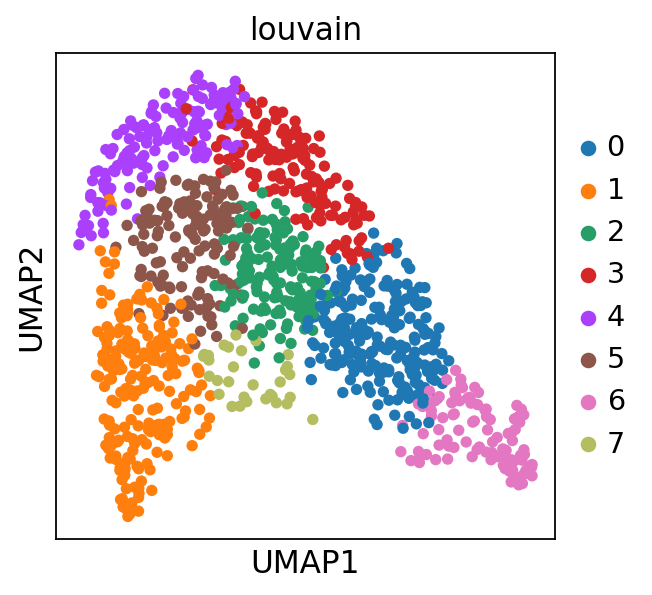

In [184]:
sc.pl.umap(adata_31_32,color=['louvain'])

In [187]:
sc.tl.ingest

AttributeError: module 'scanpy.tools' has no attribute 'ingest'

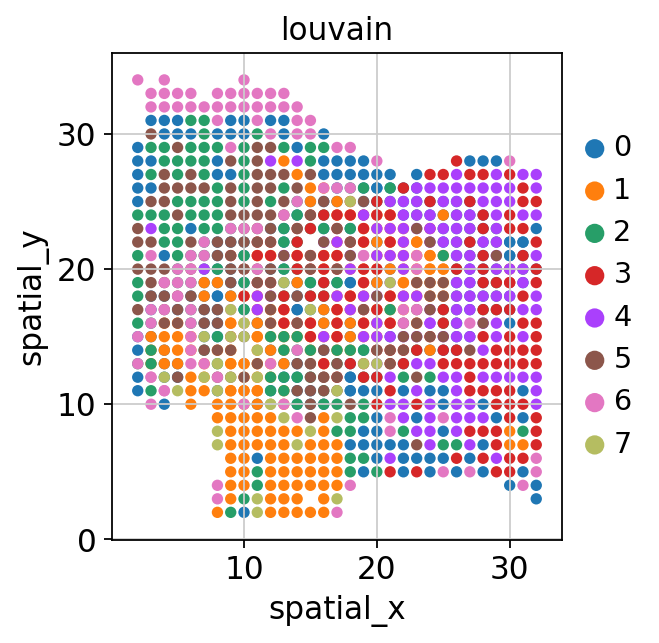

In [185]:
sc.pl.scatter(adata_31_32,x='spatial_x',y='spatial_y',color='louvain')

ranking genes
    finished (0:00:00)


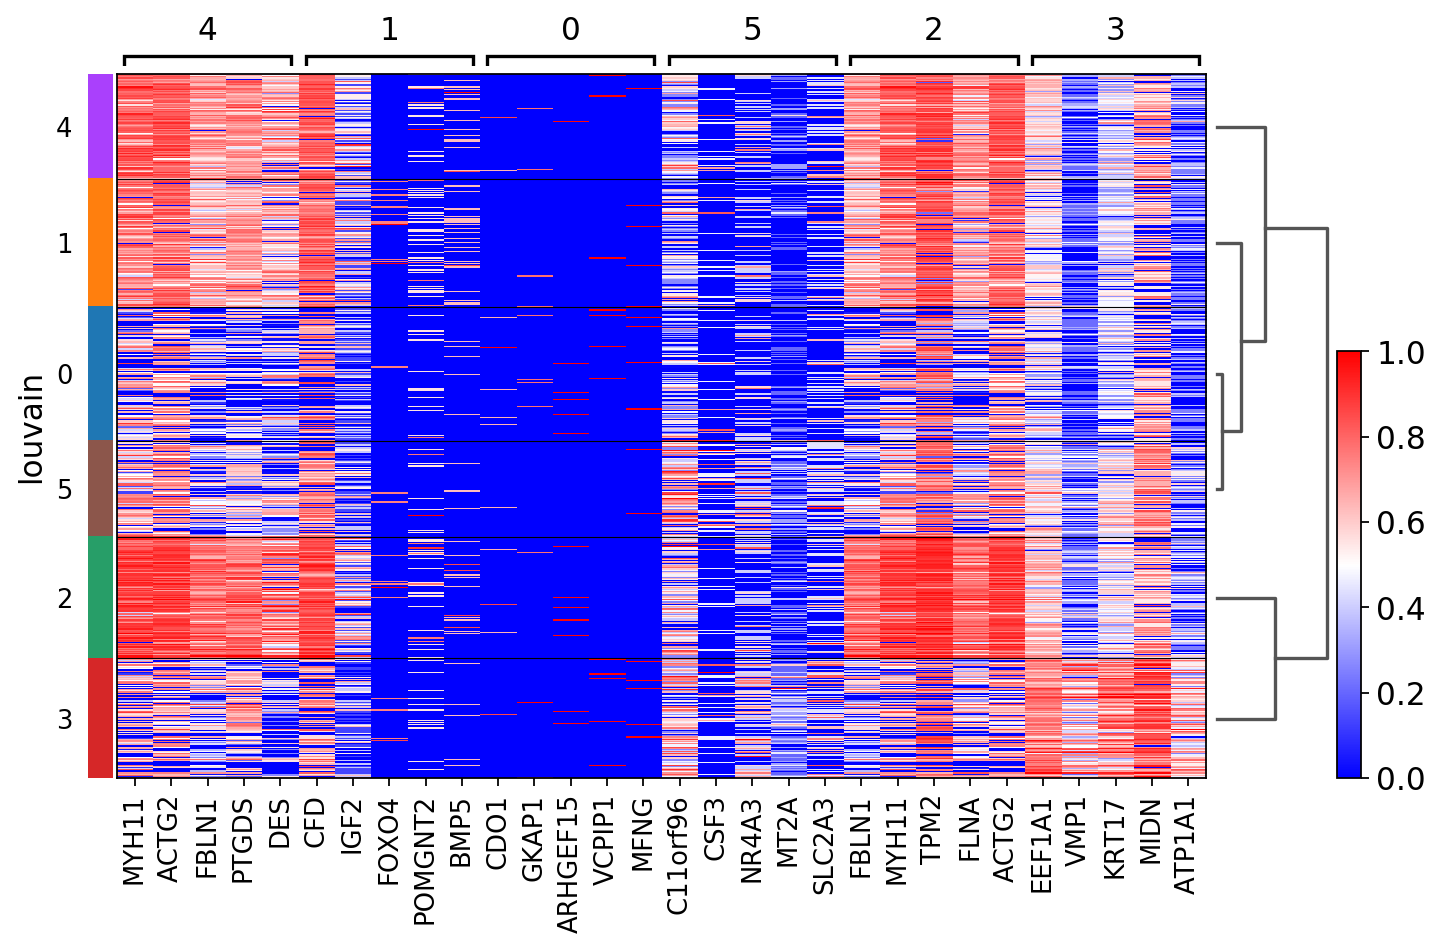

In [126]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test')

sc.pl.rank_genes_groups_heatmap(adata, n_genes=5,standard_scale='var', cmap='bwr',dendrogram=True,log=True)

In [4]:
data_name='SPE1'
num_features=718
# data_name='20190115_liverfiber1_filter'
# num_features=198


path_pref='/home/yzy/bioSIMS/data/process/'
bg_threshold=0
figformat='png'
figsize=(10,10)

test_sample_path = '{0}{1}/preprocess/'.format(path_pref,data_name)


test_sample_file = 'test_samples_{0}.mat'.format(str(num_features))

test_sample_file_20 = 'test_samples_20.mat'
test_sample_file = test_sample_path+test_sample_file
test_sample_file_20 = test_sample_path+test_sample_file_20


matters_candidate_file = 'matters_candidate.pkl'
matters_candidate_file = test_sample_path+matters_candidate_file
test_samples = sio.loadmat(test_sample_file)
test_samples = test_samples['test_samples']
test_samples_20 = sio.loadmat(test_sample_file_20)
test_samples_20 = test_samples_20['test_samples']
matters_list = pickle.load(open(matters_candidate_file,'rb'))

In [120]:
a = np.arange(16)
a_sq = a.reshape(4,4)

In [126]:
x_list = [np.where(a_sq==i)[1][0] for i in a]

In [127]:
x_list

[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]

In [5]:
in_X = test_samples
# obs_name = cell_list
obs_name = map(str,range(in_X.shape[0]))
g = map(str,matters_list)
# g = matters_list

obs = pd.DataFrame(index=obs_name)

# var_name must be str
var = pd.DataFrame(index=g)

adata = ad.AnnData(in_X,  obs=obs,var=var, dtype='float32')
a_tmp = np.arange(65536)
a_tmp_sq = a_tmp.reshape(256,256)
x_list = [np.where(a_tmp_sq==i)[0][0] for i in a_tmp]
y_list = [np.where(a_tmp_sq==i)[1][0] for i in a_tmp]

# adata.obsm['spatial'] = np.concatenate((x_list.reshape(-1,1),y_list.reshape(-1,1)),axis=1)
adata.obs['spatial_x'] = y_list
adata.obs['spatial_y'] = x_list

In [137]:
adata.obs['spatial_x'] = x_list
adata.obs['spatial_y'] = y_list

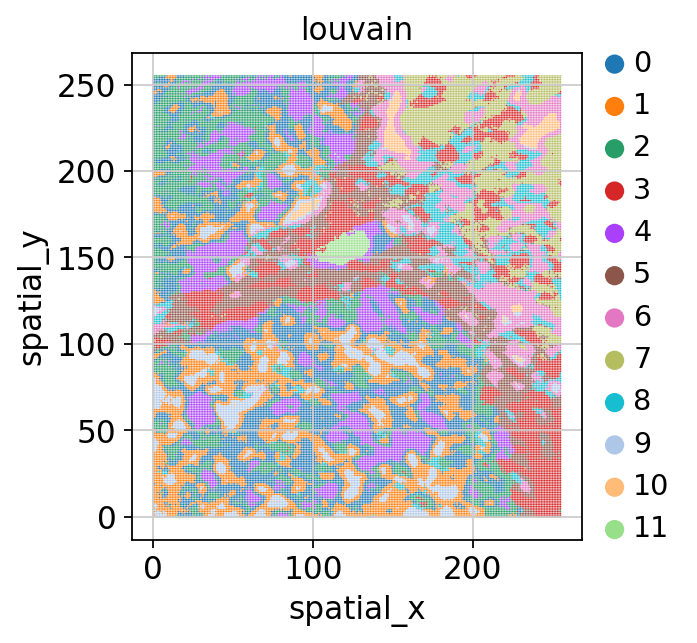

In [105]:
sc.pl.scatter(image_full,x='spatial_x',y='spatial_y',color='louvain',)

In [75]:
# compactness_col越大，superpixel越规则
# 需要设定规则，使得superpixel不会因为spatial远而断掉，只要连续.在SNIC结束后加一步
image_full_2, distance_map, real_number_of_pixels = ST_snic(adata,compactness_col=1,neighbor_k=4,num_grid=100)
gene_names,gene_repmat = get_gene_rep(image_full_2)

normalizing by total count per cell
    finished ({time_passed}): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04)
computing UMAP
    finished (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)
processed 81.42%


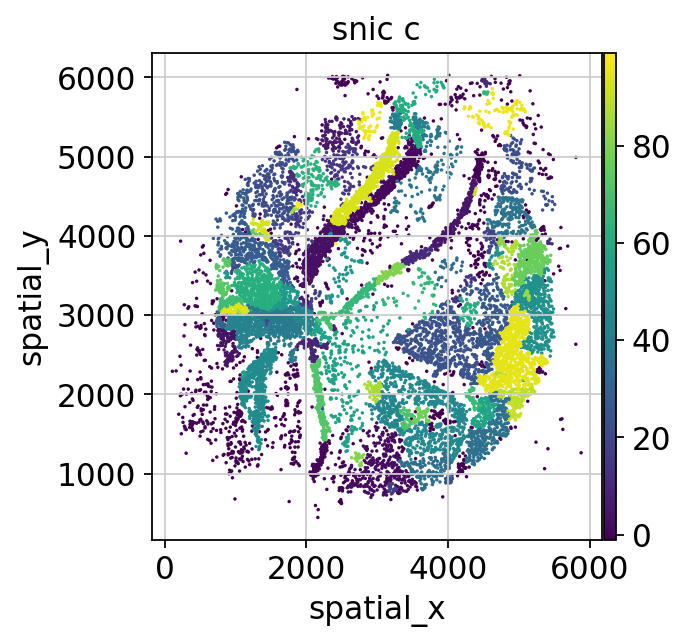

In [76]:
sc.pl.scatter(image_full_2,x='spatial_x',y='spatial_y',color='snic_c',)

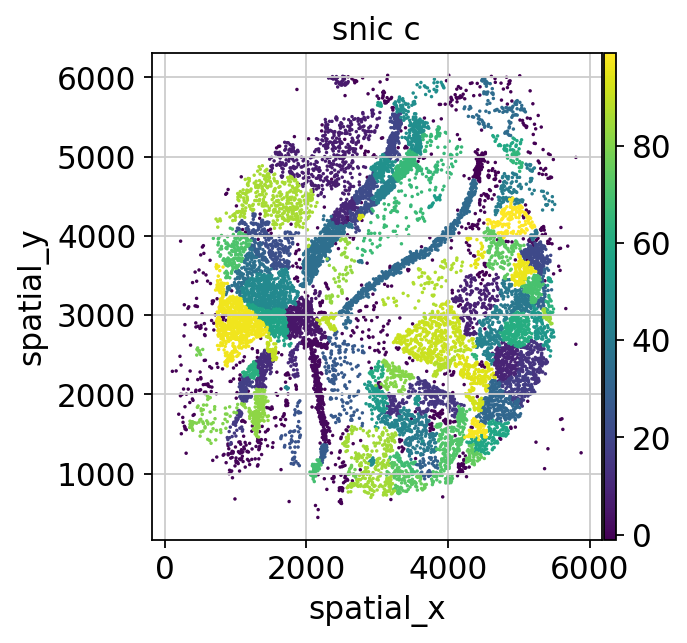

In [64]:
sc.pl.scatter(image_full_2,x='spatial_x',y='spatial_y',color='snic_c',)

In [358]:
sns.set(style='white')

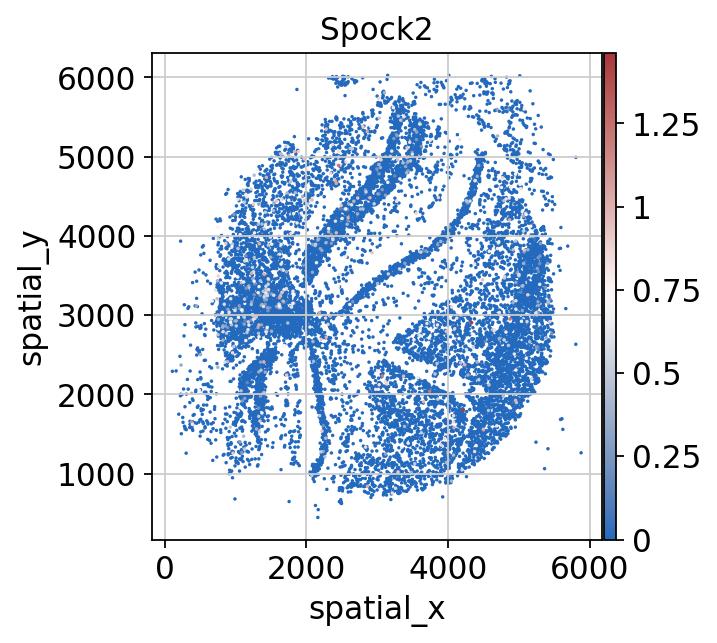

In [69]:
sc.pl.scatter(image_full_2,x='spatial_x',y='spatial_y',color='Spock2',color_map='vlag')

In [438]:
int_gene = 'Ttr'
use_gene_name = np.array(image_full_2.var_names)
int_idx = np.where(use_gene_name==int_gene)[0][0]
int_row = dist_mat[int_idx,:]
int_argsort = np.argsort(int_row)
use_gene_name[int_argsort][:10]


array(['Ttr', 'Enpp2', 'Fth1', 'mt-Rnr2', '1500015O10Rik', 'Malat1',
       'mt-Cytb', 'mt-Nd1', 'Apoe', 'Cox4i1'], dtype=object)

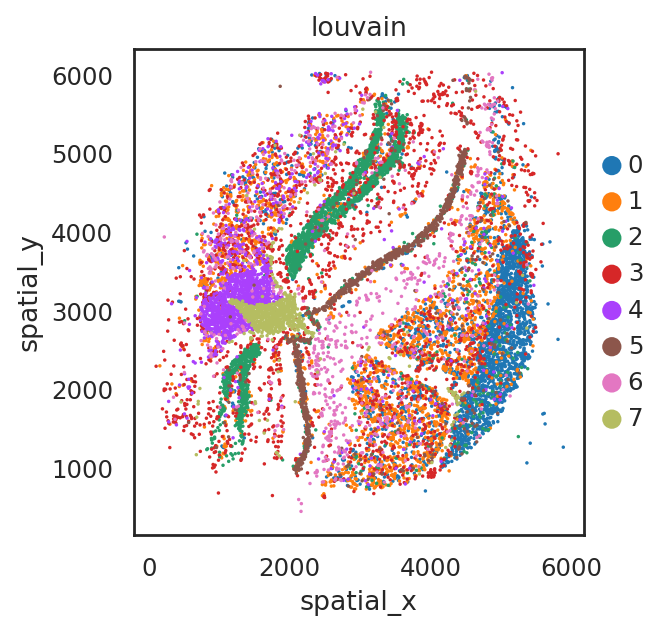

In [367]:
sc.pl.scatter(image_full_2,x='spatial_x',y='spatial_y',color='louvain',)

In [65]:
gene_repmat_minmax = gene_repmat/np.sum(gene_repmat,axis=1,keepdims=1)
dist_mat_soger = squareform(pdist(gene_repmat_minmax,'correlation'))
# gene_repmat_minmax: correlation>cosine>euclidean
# gene_repmat:correlation>cosine>>euclidean

In [66]:
gene_repmat_minmax.shape

(3235, 101)

In [28]:
image_full_2.shape

(12282, 3235)

In [45]:
gene_repmat_ori = np.transpose(image_full_2.X)
dist_mat = squareform(pdist(gene_repmat_ori,'correlation'))
# correlation>>cosine>euclidean

In [70]:
int_gene = 'Ttr'
dist_mat_use = dist_mat_soger
use_gene_name = np.array(image_full_2.var_names)
int_idx = np.where(use_gene_name==int_gene)[0][0]
int_row = dist_mat_use[int_idx,:]
int_sort = np.sort(int_row)
int_argsort = np.argsort(int_row)
use_gene_name[int_argsort][:10]


array(['Ttr', 'Vamp8', 'Fxyd1', 'Igfbp2', 'Enpp2', '1500015O10Rik',
       'Ifi27', 'Spint2', 'Rbp1', 'Gng5'], dtype=object)

In [470]:
int_sort[1]

0.05529031048585198

In [435]:
np.where(np.array(use_gene_name)=='Ttr')[0][0]

2995

In [315]:
sc.tl.rank_genes_groups(image_full_2, 'louvain', method='t-test')


ranking genes
    finished (0:00:01)


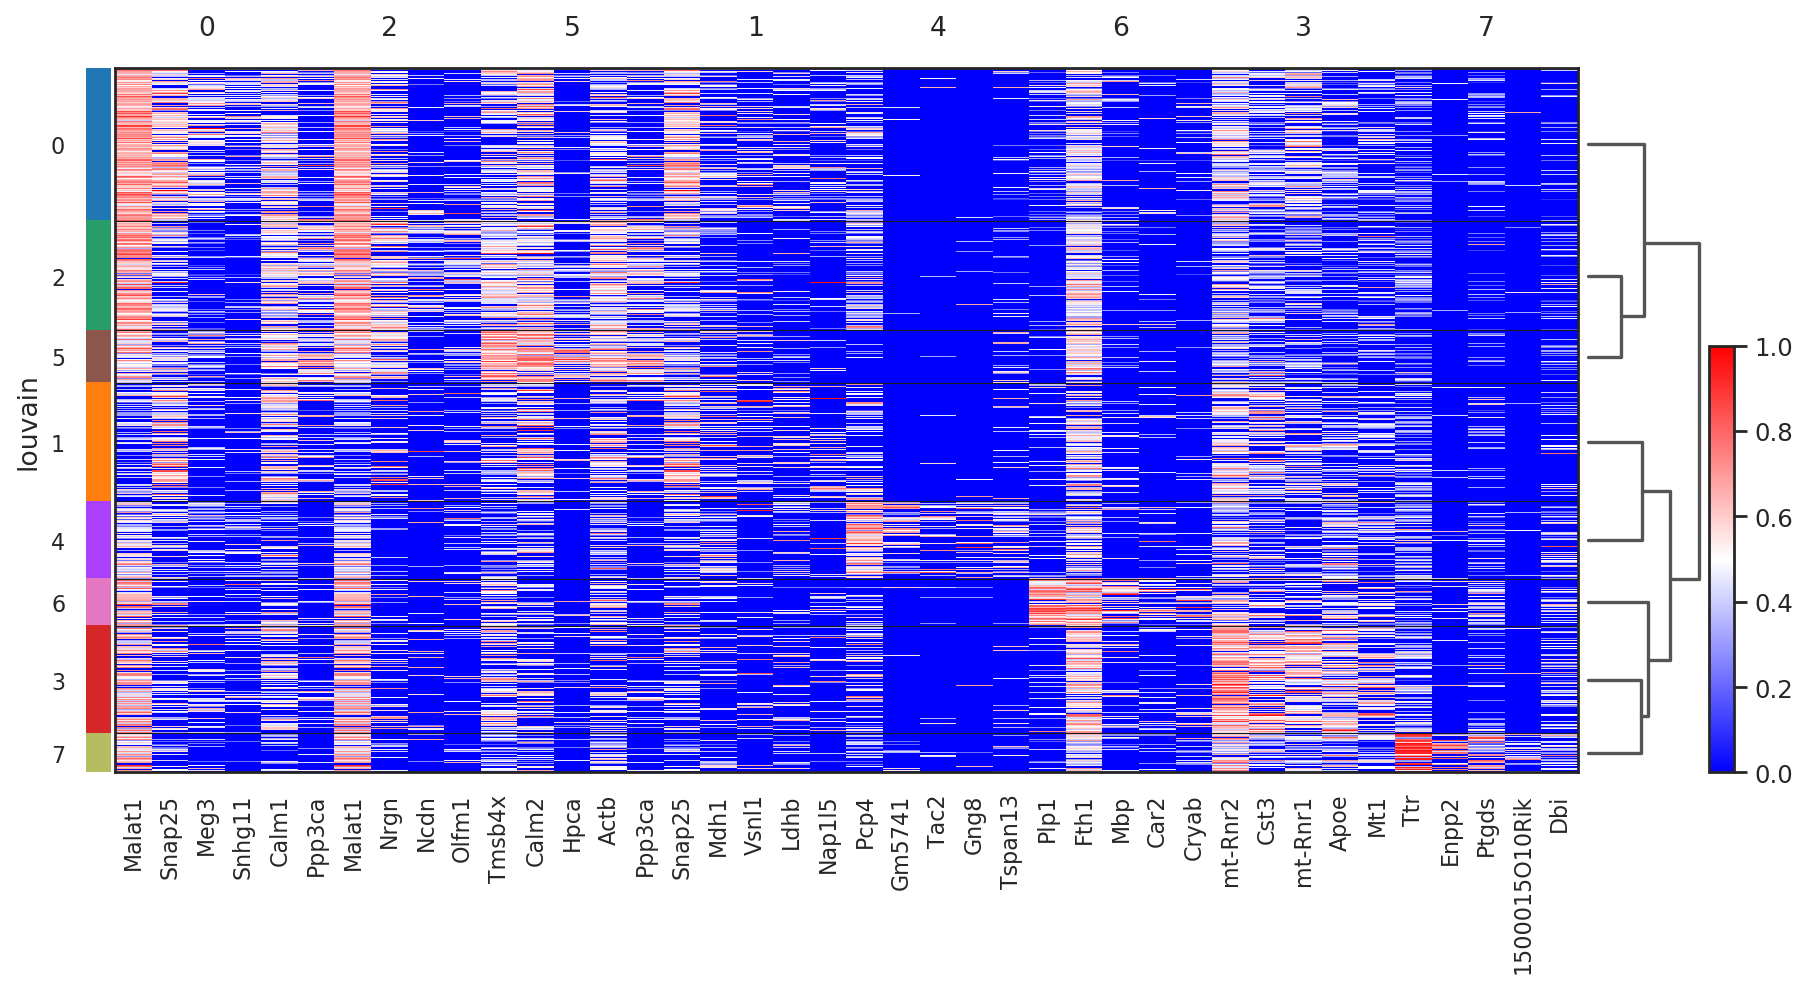

In [371]:
sc.tl.rank_genes_groups(image_full_2, 'louvain', method='t-test')

sc.pl.rank_genes_groups_heatmap(image_full_2, n_genes=5,standard_scale='var', cmap='bwr',dendrogram=True,log=True)

In [151]:
image_full.obs['snic']=[label_map[image_full.obs['spatial_x'][i],image_full.obs['spatial_y'][i]] for i in range(num_points)]
image_full.obs['snic'] = image_full.obs['snic'].astype('category')

In [183]:
image_full_2[image_full_2.obs['snic_d']==23]

View of AnnData object with n_obs × n_vars = 25 × 3235 
    obs: 'barcode', 'spatial_x', 'spatial_y', 'n_counts', 'louvain', 'snic_c', 'snic_d'
    var: 'ENSEMBL'
    uns: 'pca', 'neighbors', 'louvain'
    obsm: 'spatial', 'X_pca', 'X_umap'
    varm: 'PCs'

In [211]:
a = cell_avg_mat[13]
b = a[None]

In [266]:
cell_avg_mat[11].shape

(3235, 1)

In [276]:
image_full_2[image_full_2.obs['snic_d']==12].X.shape

(3235,)

In [283]:
cell_avg_mat[12].shape

(3235, 1)

In [287]:
gene_repmat

array([[ 4.2133923 ,  0.        ,  2.4059715 , ...,  0.4054651 ,
         0.25847414,  0.7843959 ],
       [27.300968  ,  0.        ,  3.143191  , ...,  2.692039  ,
         3.7460356 ,  1.2769883 ],
       [66.86122   ,  0.95643973,  7.397088  , ..., 13.538517  ,
         2.833162  ,  1.0227934 ],
       ...,
       [17.333002  ,  0.65058756,  0.        , ...,  2.873643  ,
         0.30072978,  0.        ],
       [33.59706   ,  0.6958317 ,  0.72685826, ...,  0.70679   ,
         0.26360416,  0.9531928 ],
       [76.54042   ,  2.4435637 ,  0.72391886, ...,  6.76813   ,
         0.48965722,  0.        ]], dtype=float32)

In [286]:

cell_avg_mat = []
for i in np.unique(image_full_2.obs['snic_d']):
    cur_ad = image_full_2[image_full_2.obs['snic_d']==i]
#     换成mean？
    
    if cur_ad.shape[0]==1:
        cur_avg = np.array(cur_ad.X)[:,None]
    else:
        cur_avg = np.array(np.sum(cur_ad.X,axis=0,keepdims=1))
        cur_avg = np.transpose(cur_avg)
#     cur_avg = np.transpose(cur_avg)
    cell_avg_mat.append(cur_avg)
gene_repmat = np.concatenate(cell_avg_mat,axis=1)


In [460]:
gene_repmat

array([[ 4.2133923 ,  0.        ,  2.4059715 , ...,  0.4054651 ,
         0.25847414,  0.7843959 ],
       [27.300968  ,  0.        ,  3.143191  , ...,  2.692039  ,
         3.7460356 ,  1.2769883 ],
       [66.86122   ,  0.95643973,  7.397088  , ..., 13.538517  ,
         2.833162  ,  1.0227934 ],
       ...,
       [17.333002  ,  0.65058756,  0.        , ...,  2.873643  ,
         0.30072978,  0.        ],
       [33.59706   ,  0.6958317 ,  0.72685826, ...,  0.70679   ,
         0.26360416,  0.9531928 ],
       [76.54042   ,  2.4435637 ,  0.72391886, ...,  6.76813   ,
         0.48965722,  0.        ]], dtype=float32)

In [9]:
def get_gene_rep(adata):
    image_full_2 = adata.copy()
    cell_avg_mat = []
    for i in np.unique(image_full_2.obs['snic_d']):
        cur_ad = image_full_2[image_full_2.obs['snic_d']==i]
    #     换成mean？

        if cur_ad.shape[0]==1:
            cur_avg = np.array(cur_ad.X)[:,None]
        else:
            cur_avg = np.array(np.sum(cur_ad.X,axis=0,keepdims=1))
            cur_avg = np.transpose(cur_avg)
    #     cur_avg = np.transpose(cur_avg)
        cell_avg_mat.append(cur_avg)
    gene_repmat = np.concatenate(cell_avg_mat,axis=1)
    return list(image_full_2.var_names),gene_repmat

In [18]:
gene_names,gene_repmat = get_gene_rep(image_full_2)

In [297]:
gene_SIMLR,_ = SIMLR(gene_repmat,k=-10)

In [418]:
save_path = 'test/online_projection/'
save_file = 'slideseq_ori_scale_rowminmax'
# use_rep = gene_repmat
use_rep = np.transpose(image_full_2.X)
use_rep = use_rep/np.sum(use_rep,axis=1,keepdims=1)

# with open(save_path+save_file+'_mtx','w') as f:
#     for i in range(use_rep.shape[0]):
#         cur_line = '\t'.join(list(use_rep[i].astype('str')))
#         cur_line+='\n'
#         f.write(cur_line)

In [421]:
use_cls = gene_SIMLR
use_gene_name = gene_names
# with open(save_path+save_file+'_meta','w') as f:
#     f.write('name'+'\t'+'cls'+'\n')
#     for i in range(use_rep.shape[0]):
#         cur_name = str(use_gene_name[i])
#         cur_cls = str(use_cls[i])
# #         cur_manual = str(SPE1_cluster_manual[i])
#         cur_line = cur_name+'\t'+cur_cls+'\n'
#         f.write(cur_line)

In [10]:
def ST_snic(adata,compactness_col,neighbor_k):
    image_full = adata.copy()
#     compactness_col = 1
#     neighbor_k = 4

#     update_func = None
    image_distance=None
    #把image转为3维[0,1]
    sc.pp.normalize_per_cell(image_full)
    sc.pp.log1p(image_full)
    image_full.raw = image_full
    sc.tl.pca(image_full, svd_solver='arpack')
    sc.pp.neighbors(image_full)
    sc.tl.umap(image_full,n_components=3)
    sc.tl.louvain(image_full)


    num_points = image_full.shape[0]
    spatial_key = [(image_full.obs['spatial_x'][i],image_full.obs['spatial_y'][i]) for i in range(num_points)]
    label_map_val = [-1]*num_points
    distance_map_val = [sys.float_info.max]*num_points
    image_val = [image_full.obsm['X_umap'][i] for i in range(num_points)]

    # [x,y]->label
    label_map = dict(zip(spatial_key,label_map_val))

    # [x,y]->distance to centroid
    distance_map = dict(zip(spatial_key,distance_map_val))

    # [x,y]->np.array of (3,)
    image = dict(zip(spatial_key,image_val))

    # calculate compactness_img
    neighbor_dict,compactness_img = get_k_neighbourhood_and_compactness_img(neighbor_k, spatial_key)


    # list of tuple (x,y)
    grid = None
    num_grid = 200
    grid_idx = np.random.choice(num_points,num_grid,replace=False)
    grid = [spatial_key[i] for i in grid_idx]
    real_number_of_pixels = len(grid)

    centroids_pos = grid
    centroids = [[pos,image[pos],0] for pos in centroids_pos]


    queue = Queue(num_points * 4)  # [position, color, centroid_idx]
    q_add = queue.add  # cache some functions
    q_pop = queue.pop

    for k in range(real_number_of_pixels):
        init_centroid = centroids[k]
        q_len = -queue.length()
        q_add(q_len, [init_centroid[0], init_centroid[1], k])
        distance_map[init_centroid[0]] = q_len

    if image_distance is None:
        image_distance = create_augmented_snic_distance(num_points, real_number_of_pixels, compactness_img,compactness_col)

    update_func=lambda num_pixels: print("processed %05.2f%%" % (num_pixels * 100 / number_of_pixels))
    number_of_pixels=num_points


    classified_pixels = 0
    try:
        while True:
    #         print('aaa')
            item = q_pop()
            candidate_distance = item._key
            candidate = item.value
            candidate_pos = candidate[0]
            if label_map[candidate_pos] == -1:
                centroid_idx = candidate[2]
    #             print('bbb')

                # label new pixel
                label_map[candidate_pos] = centroid_idx
                #
                distance_map[candidate_pos] = candidate_distance
                # label_map[candidate_pos[1] * im_width + candidate_pos[0]] = centroid_idx
                classified_pixels += 1

                # online update of centroid
                centroid = centroids[centroid_idx]
                num_pixels = centroid[2] + 1
                lerp_ratio = 1 / num_pixels

                # adjust centroid position
                centroid[0] = lerp2(centroid[0], candidate_pos, lerp_ratio)
                # update centroid color
                centroid[1] = lerp_nd(centroid[1], candidate[1], lerp_ratio)
                # adjust number of pixels counted towards this super pixel
                centroid[2] = num_pixels

                # add new candidates to queue
                #!!!!!!!!!!!!!!!!!可以提前算好
    #             neighbours, neighbour_num = get_4_neighbourhood_1(candidate_pos, image_size)
                neighbours_idx = neighbor_dict[candidate_pos]
                neighbour_num = len(neighbours_idx)
                neighbours = [spatial_key[i] for i in neighbours_idx]
                for i in range(neighbour_num):
                    neighbour_pos = neighbours[i]
                    # Check if neighbour is already labeled, as these pixels would get discarded later on.
                    # We filter them here as queue insertions are expensive
                    # if label_map[neighbour_pos[1] * im_width + neighbour_pos[0]] == -1:
                    if label_map[neighbour_pos] == -1:
                        neighbour_color = image[neighbour_pos]
                        neighbour = [neighbour_pos, neighbour_color, centroid_idx]
                        #!!!!!!!!!!!!!!!!!
                        distance = image_distance(neighbour_pos, centroid[0], neighbour_color, centroid[1])

                        # test if another candidate with a lower distance, is not already
                        # registered to this pixel
                        if distance_map[neighbour_pos] >= distance:
                            distance_map[neighbour_pos] = distance
                            q_add(distance, neighbour)

                # status update
                if (update_func is not None) and (classified_pixels % 10000 == 0):
                    update_func(classified_pixels)
    except IndexError:
        pass
    
    image_full.obs['snic_c']=[label_map[image_full.obs['spatial_x'][i],image_full.obs['spatial_y'][i]] for i in range(num_points)]
    image_full.obs['snic_d'] = image_full.obs['snic_c'].astype('category')

    return image_full, distance_map, real_number_of_pixels

In [11]:
image_full_2, distance_map, real_number_of_pixels = ST_snic(adata,compactness_col=10,neighbor_k=4)

normalizing by total count per cell
    finished ({time_passed}): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:07)
computing UMAP
    finished (0:00:15)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)
processed 81.42%


In [124]:
image_full = adata.copy()
compactness_col = 1
neighbor_k = 4

update_func = None

In [125]:
#把image转为3维[0,1]
sc.pp.normalize_per_cell(image_full)
sc.pp.log1p(image_full)
image_full.raw = image_full
sc.tl.pca(image_full, svd_solver='arpack')
sc.pp.neighbors(image_full)
sc.tl.umap(image_full,n_components=3)
sc.tl.louvain(image_full)

normalizing by total count per cell
    finished ({time_passed}): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished (0:00:04)
computing UMAP
    finished (0:00:14)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01)


In [375]:
count_mat_file = 'test/sc/DEG_count_matrix.csv'
a_test=sc.read_csv(count_mat_file, delimiter=',', first_column_names=None)

In [381]:
gene_rep_test = a_test.X
gene_names = list(a_test.obs_names)

In [382]:
gene_rep_test = gene_rep_test/np.sum(gene_rep_test,axis=0)

In [385]:
gene_SILMR,_ = SIMLR(gene_rep_test,k=-10)

In [388]:
save_path = 'test/online_projection/'
save_file = 'SIMSgene_ori_scale_minmaxrow'
# use_rep = gene_repmat
use_rep = gene_rep_test
use_rep = use_rep/np.sum(use_rep,axis=1,keepdims=1)

with open(save_path+save_file+'_mtx','w') as f:
    for i in range(use_rep.shape[0]):
        cur_line = '\t'.join(list(use_rep[i].astype('str')))
        cur_line+='\n'
        f.write(cur_line)

In [387]:
use_cls = gene_SIMLR
use_gene_name = gene_names
with open(save_path+save_file+'_meta','w') as f:
    f.write('name'+'\t'+'cls'+'\n')
    for i in range(use_rep.shape[0]):
        cur_name = str(use_gene_name[i])
        cur_cls = str(use_cls[i])
#         cur_manual = str(SPE1_cluster_manual[i])
        cur_line = cur_name+'\t'+cur_cls+'\n'
        f.write(cur_line)

In [391]:
a_test.X = use_rep

In [393]:
sc.tl.pca(a_test, svd_solver='arpack')
sc.pp.neighbors(a_test, n_neighbors=10)
sc.tl.umap(a_test)
sc.tl.draw_graph(a_test)
sc.tl.louvain(a_test)

computing PCA with n_comps = 50
    finished (0:00:00)
computing neighbors
    using data matrix X directly
    finished (0:00:00)
computing UMAP


/home/yzy/anaconda3/envs/tensorflow/lib/python3.6/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:00)
drawing single-cell graph using layout 'fa'
    finished (0:00:00)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


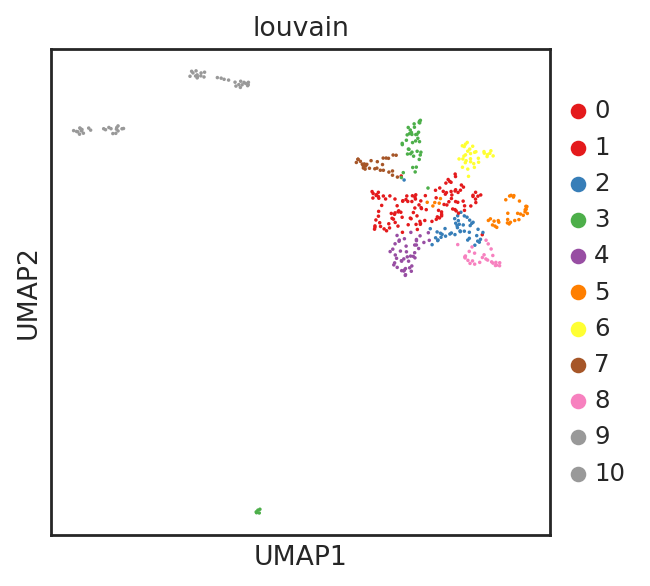

In [397]:
sc.pl.umap(a_test,color='louvain',s=10,palette='Set1')

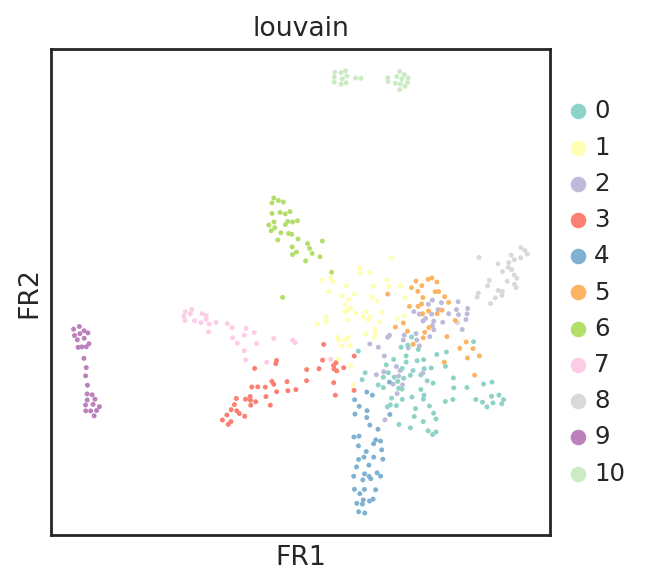

In [400]:
import palettable
cur_palette = palettable.colorbrewer.qualitative.Set3_11

sc.pl.draw_graph(a_test,color='louvain',s=20,palette=cur_palette.mpl_colors)

In [405]:
int_cls = '0'
int_idx = a_test.obs['louvain']==int_cls
a_test.obs_names[int_idx]

Index(['ACAP2', 'ACTL6A', 'ADAMTS15', 'ANKRD27', 'ASB4', 'CBFB', 'CCNT1',
       'CCT2', 'CLDN2', 'COG1', 'COMMD2', 'CORO2B', 'COX8A', 'CTNS', 'CYP1A1',
       'DNAJC14', 'DOK3', 'DUSP14', 'ECM2', 'ERV3-1', 'FAM71C', 'FBXO22',
       'FKBP14', 'FUBP1', 'GABRR2', 'GPR34', 'GTF3C3', 'HTATIP2', 'HTR7',
       'IRAK2', 'JKAMP', 'KSR2', 'LDC1P', 'MIPOL1', 'MTCO2P19', 'MYB', 'NXN',
       'OR2T11', 'OR51F4P', 'PAIP1', 'PART1', 'PFDN5', 'POP4', 'PPP1R1C',
       'PSMC6', 'RAB34', 'RANBP3L', 'SERPINE2', 'SLC17A4', 'SLC3A2', 'SSC4D',
       'SYNDIG1L', 'TINAGL1', 'TLR10', 'TMEM177', 'TMEM33', 'TP53BP1', 'TPGS2',
       'TRBV7-2', 'TSTD1', 'TUBB8', 'TYW1', 'USP21', 'WDR3', 'Z68871.1',
       'ZNF281', 'ZNF319', 'ZNF778', 'ZSCAN30'],
      dtype='object')

In [472]:
genes_cls_list = []
max_len = 0
for i in range(11):
    int_cls = str(i)
    int_idx = a_test.obs['louvain']==int_cls
    cur_genes = list(a_test.obs_names[int_idx])
    genes_cls_list.append(cur_genes)
    max_len = max(len(cur_genes),max_len)
    

In [ ]:
1+1

69

In [478]:
genes_cls_list_samelen = []
for l in genes_cls_list:
    cur_len = len(l)
    l.extend(['']*(max_len-cur_len))
    genes_cls_list_samelen.append(l)

In [484]:
with open('test/sc/gene_cls.txt','w') as f:
    for i in range(max_len):
        cur_line = []
        for l in genes_cls_list_samelen:
            cur_gene = l[i]
            cur_line.append(cur_gene)
        cur_line_str = ','.join(cur_line)
        cur_line_str += '\n'
        f.write(cur_line_str)
        
        
    
    

In [1]:
1+1

2